<a href="https://colab.research.google.com/github/sainithinkatta/deep-learning/blob/main/DL_Project_Group05.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import zipfile

zip_path = '/content/drive/MyDrive/Colab Notebooks/MOT16.zip'
extract_path = '/content/MOT16'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

In [ ]:
import os

print("Train sequences:", os.listdir("/content/MOT16/train"))
print("Test sequences:", os.listdir("/content/MOT16/test"))

Train sequences: ['MOT16-05', 'MOT16-11', 'MOT16-10', 'MOT16-02', 'MOT16-13', 'MOT16-09', 'MOT16-04']
Test sequences: ['MOT16-01', 'MOT16-03', 'MOT16-06', 'MOT16-12', 'MOT16-07', 'MOT16-14', 'MOT16-08']


In [ ]:
import numpy as np

#Parsing MOT ground-truth file.
def parse_gt_file(file_path):
    data = []
    with open(file_path, "r") as f:
        for line in f:
            parts = line.strip().split(",")
            if len(parts) < 6:
                continue
            f_id, obj_id, x, y, w, h = parts[:6]
            data.append({
                "frame_id": int(float(f_id)),
                "object_id": int(float(obj_id)),
                "bb_left": float(x),
                "bb_top": float(y),
                "bb_width": float(w),
                "bb_height": float(h),
            })
    return data

In [ ]:
# Data Augumentation
from torchvision import transforms

data_augmentation = transforms.Compose([
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.1),
    transforms.GaussianBlur(kernel_size=5, sigma=(0.1, 2.0))
])

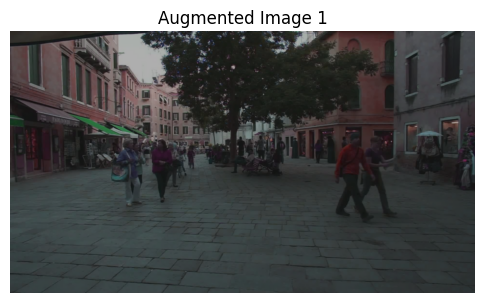

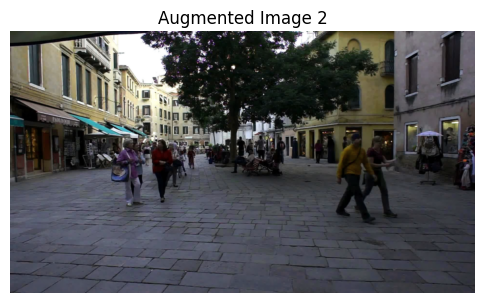

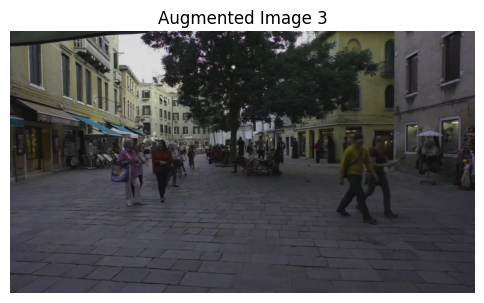

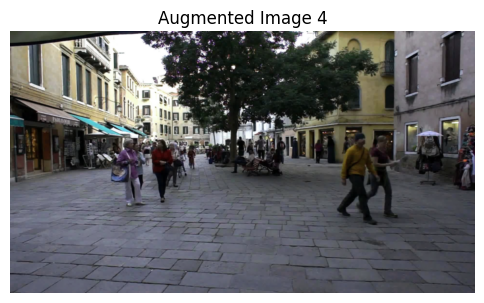

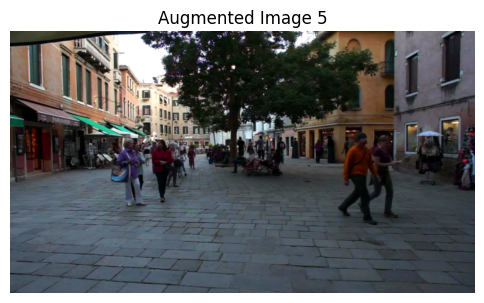

In [ ]:
import os
import matplotlib.pyplot as plt
from PIL import Image
import torch
from torch.utils.data import Dataset

# Augumentation
class MOTVisualDataset(Dataset):
    def __init__(self, img_dir, transform=None, augmentation=None):
        self.img_dir = img_dir
        self.image_files = sorted([f for f in os.listdir(img_dir) if f.endswith('.jpg')])
        self.transform = transform
        self.augmentation = augmentation

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.image_files[idx])
        img = Image.open(img_path).convert("RGB")

        if self.augmentation:
            img = self.augmentation(img)

        if self.transform:
            img = self.transform(img)

        return img

visual_dataset = MOTVisualDataset(
    img_dir="/content/MOT16/train/MOT16-02/img1",
    transform=transforms.ToTensor(),
    augmentation=data_augmentation
)

N = 5

for i in range(N):
    img = visual_dataset[i]
    img_np = img.permute(1, 2, 0).numpy()
    img_np = (img_np * 255).astype("uint8")

    plt.figure(figsize=(6, 6))
    plt.imshow(img_np)
    plt.title(f"Augmented Image {i+1}")
    plt.axis("off")
    plt.show()

In [ ]:
# Dataset and Dataloader for detector (faster r-cnn).

import os
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

# Dataset class with augmentation + bbox parsing.
class MOTDataset(Dataset):
    def __init__(self, img_dir, gt_path, transform=None, augmentation=None):
        self.img_dir = img_dir
        self.gt_data = parse_gt_file(gt_path)
        self.transform = transform
        self.augmentation = augmentation
        self.frame_ids = sorted({d["frame_id"] for d in self.gt_data})

    def __len__(self):
        return len(self.frame_ids)

    def __getitem__(self, idx):
        fid = self.frame_ids[idx]
        img_path = os.path.join(self.img_dir, f"{fid:06d}.jpg")
        if not os.path.exists(img_path):
            raise FileNotFoundError(f"Image {img_path} not found!")

        img = Image.open(img_path).convert("RGB")
        boxes, labels = [], []

        for obj in self.gt_data:
            if obj["frame_id"] == fid:
                x1 = obj["bb_left"]
                y1 = obj["bb_top"]
                x2 = x1 + obj["bb_width"]
                y2 = y1 + obj["bb_height"]
                boxes.append([x1, y1, x2, y2])
                labels.append(1)  # all objects have label 1

        target = {
            "boxes": torch.tensor(boxes, dtype=torch.float32),
            "labels": torch.tensor(labels, dtype=torch.int64),
        }

        if self.augmentation:
            img = self.augmentation(img)

        if self.transform:
            img = self.transform(img)

        return img, target

def collate_fn(batch):
    return tuple(zip(*batch))

det_transform = transforms.Compose([
    transforms.ToTensor(),
])

# Dataset with augmentation for training.
det_dataset = MOTDataset(
    img_dir="/content/MOT16/train/MOT16-02/img1",
    gt_path="/content/MOT16/train/MOT16-02/gt/gt.txt",
    transform=det_transform,
    augmentation=data_augmentation
)

det_loader = DataLoader(det_dataset, batch_size=2, shuffle=True, collate_fn=collate_fn)

In [ ]:
# Building and Fine-Tuning Faster R-CNN Detector
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torch.optim import AdamW

def get_detector(num_classes=2):
    model = fasterrcnn_resnet50_fpn(pretrained=True)
    in_feats = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_feats, num_classes)
    return model

# Initializing the model and the optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_det = get_detector(num_classes=2).to(device)
optimizer_det = AdamW([p for p in model_det.parameters() if p.requires_grad], lr=5e-4)

# Training the loop
num_epochs_det = 15
for epoch in range(num_epochs_det):
    model_det.train()
    epoch_loss = 0.0

    for imgs, targets in det_loader:
        imgs = [img.to(device) for img in imgs]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model_det(imgs, targets)
        loss = sum(loss for loss in loss_dict.values())

        optimizer_det.zero_grad()
        loss.backward()
        optimizer_det.step()

        epoch_loss += loss.item()

    print(f"Epoch {epoch+1}/{num_epochs_det} Loss: {epoch_loss / len(det_loader):.4f}")

# Saving model weights.
save_path = '/content/drive/MyDrive/fasterrcnn_finetuned.pth'
torch.save(model_det.state_dict(), save_path)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:01<00:00, 127MB/s]


Epoch 1/15 Loss: 1.5435
Epoch 2/15 Loss: 0.9470
Epoch 3/15 Loss: 0.7286
Epoch 4/15 Loss: 0.5819
Epoch 5/15 Loss: 0.5038
Epoch 6/15 Loss: 0.4362
Epoch 7/15 Loss: 0.3938
Epoch 8/15 Loss: 0.3619
Epoch 9/15 Loss: 0.3352
Epoch 10/15 Loss: 0.3115
Epoch 11/15 Loss: 0.2960
Epoch 12/15 Loss: 0.2816
Epoch 13/15 Loss: 0.2702
Epoch 14/15 Loss: 0.2585
Epoch 15/15 Loss: 0.2488


In [ ]:
import torch
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.ops import box_iou
from sklearn.metrics import accuracy_score, precision_score, f1_score
from tqdm.auto import tqdm

# Calculating the accuracy, precesion and F1 scores.
FASTER_RCNN_PATH = '/content/drive/MyDrive/fasterrcnn_finetuned.pth'
BATCH_SIZE       = 1
IOU_THRESH       = 0.5
SCORE_THRESH     = 0.5
DEVICE           = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def load_model(weights_path: str, device: torch.device):
    model = fasterrcnn_resnet50_fpn(weights=None, weights_backbone=None, num_classes=2)
    state = torch.load(weights_path, map_location=device)
    model.load_state_dict(state)
    return model.to(device).eval()

img_dir = "/content/MOT16/train/MOT16-02/img1"
gt_path = "/content/MOT16/train/MOT16-02/gt/gt.txt"

dataset = MOTDataset(img_dir=img_dir, gt_path=gt_path, transform=det_transform)
loader  = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)

def evaluate(model, data_loader):
    all_preds, all_gts = [], []

    for imgs, targets in tqdm(data_loader, desc="Evaluating"):
        img_tensor = imgs[0].to(DEVICE)
        gt_boxes   = targets[0]['boxes'].to(DEVICE)

        out = model([img_tensor])[0]
        keep = out['scores'] > SCORE_THRESH
        pred_boxes = out['boxes'][keep]

        if pred_boxes.numel() == 0:
            all_gts.extend([1] * len(gt_boxes))
            all_preds.extend([0] * len(gt_boxes))
        else:
            ious = box_iou(pred_boxes, gt_boxes)
            max_iou_vals, gt_inds = ious.max(dim=1)

            matched = set()
            for iou_val, gt_idx in zip(max_iou_vals, gt_inds):
                if iou_val >= IOU_THRESH:
                    all_preds.append(1); all_gts.append(1)
                    matched.add(gt_idx.item())
                else:
                    all_preds.append(1); all_gts.append(0)
            for idx in range(len(gt_boxes)):
                if idx not in matched:
                    all_preds.append(0); all_gts.append(1)

    acc  = accuracy_score(all_gts, all_preds)
    prec = precision_score(all_gts, all_preds, zero_division=0)
    f1   = f1_score(all_gts, all_preds, zero_division=0)
    return acc, prec, f1

model = load_model(FASTER_RCNN_PATH, DEVICE)
accuracy, precision, f1score = evaluate(model, loader)

print(f"Accuracy : {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"F1 Score : {f1score:.4f}")

Evaluating:   0%|          | 0/600 [00:00<?, ?it/s]

Accuracy : 0.8729
Precision: 0.9930
F1 Score : 0.9321


In [ ]:
# Dataset for Siamese Network (Re-ID).
class SiameseDataset(Dataset):
    def __init__(self, img_dir, gt_path, transform=None, image_size=(16, 16)):
        self.img_dir = img_dir
        self.gt_data = parse_gt_file(gt_path)
        self.frame_ids = sorted({d["frame_id"] for d in self.gt_data})
        self.transform = transform
        self.image_size = image_size

        # Grouping objects by frame for efficient lookup.
        self.frames = {}
        for d in self.gt_data:
            self.frames.setdefault(d["frame_id"], []).append(d)

    def __len__(self):
        return len(self.frame_ids) * 10

    def __getitem__(self, idx):
        # Randomly sample two different frames.
        f1, f2 = np.random.choice(self.frame_ids, 2, replace=False)
        objs1, objs2 = self.frames[f1], self.frames[f2]

        # Determine if this is a positive or negative pair.
        common_ids = list({o["object_id"] for o in objs1} & {o["object_id"] for o in objs2})
        if common_ids and np.random.rand() < 0.5:
            oid = np.random.choice(common_ids)
            o1 = next(o for o in objs1 if o["object_id"] == oid)
            o2 = next(o for o in objs2 if o["object_id"] == oid)
            label = 1.0
        else:
            o1 = objs1[np.random.randint(len(objs1))]
            neg_objs = [o for o in objs2 if o["object_id"] != o1["object_id"]]
            o2 = neg_objs[np.random.randint(len(neg_objs))]
            label = 0.0

        # Cropping and preprocessing the images.
        def crop_and_resize(obj, frame_id):
            img_path = os.path.join(self.img_dir, f"{frame_id:06d}.jpg")
            if not os.path.exists(img_path):
                raise FileNotFoundError(f"Image {img_path} not found!")

            img = Image.open(img_path).convert("RGB")
            x1, y1 = int(obj["bb_left"]), int(obj["bb_top"])
            x2, y2 = x1 + int(obj["bb_width"]), y1 + int(obj["bb_height"])
            cropped_img = img.crop((x1, y1, x2, y2)).resize(self.image_size)
            return self.transform(cropped_img) if self.transform else cropped_img

        img1 = crop_and_resize(o1, f1)
        img2 = crop_and_resize(o2, f2)

        return img1, img2, torch.tensor(label, dtype=torch.float32)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Defining Siamese Network & Contrastive Loss.
class ContrastiveLoss(nn.Module):
    def __init__(self, margin=1.0):
        super().__init__()
        self.margin = margin

    def forward(self, out1, out2, label):
        dist = F.pairwise_distance(out1, out2)
        loss = (1 - label) * dist.pow(2) + label * F.relu(self.margin - dist).pow(2)
        return torch.mean(loss)


class SiameseNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(64, 128, kernel_size=3), nn.ReLU(), nn.MaxPool2d(2)
        )
        self.fc = nn.Sequential(
            nn.Linear(128 * 2 * 2, 256), nn.ReLU(),
            nn.Linear(256, 256)
        )

    def forward_once(self, x):
        x = self.conv(x)
        x = torch.flatten(x, start_dim=1)
        return self.fc(x)

    def forward(self, x1, x2):
        return self.forward_once(x1), self.forward_once(x2)

In [ ]:
from torch.optim import Adam
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Training the Siamese Network
siam_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
siam_dataset = SiameseDataset(
    img_dir="/content/MOT16/train/MOT16-02/img1",
    gt_path="/content/MOT16/train/MOT16-02/gt/gt.txt",
    transform=siam_transform,
    image_size=(16, 16)
)
siam_loader = DataLoader(siam_dataset, batch_size=32, shuffle=True)

# Model, Loss, and Optimizer
model_siam = SiameseNetwork().to(device)
criterion_siam = ContrastiveLoss(margin=1.0)
optimizer_siam = Adam(model_siam.parameters(), lr=5e-4)

# Training Loop
num_epochs_siam = 15
for epoch in range(num_epochs_siam):
    model_siam.train()
    running_loss = 0.0

    for img1, img2, labels in siam_loader:
        img1, img2, labels = img1.to(device), img2.to(device), labels.to(device)
        out1, out2 = model_siam(img1, img2)
        loss = criterion_siam(out1, out2, labels)

        optimizer_siam.zero_grad()
        loss.backward()
        optimizer_siam.step()

        running_loss += loss.item()

    print(f"Epoch {epoch+1}/{num_epochs_siam} Loss: {running_loss / len(siam_loader):.4f}")

# saving the siamese network
siam_path = '/content/drive/MyDrive/siamese_network.pth'
torch.save(model_siam.state_dict(), siam_path)

Epoch 1/15 Loss: 0.3224
Epoch 2/15 Loss: 0.3014
Epoch 3/15 Loss: 0.2981
Epoch 4/15 Loss: 0.2967
Epoch 5/15 Loss: 0.2893
Epoch 6/15 Loss: 0.2920
Epoch 7/15 Loss: 0.2865
Epoch 8/15 Loss: 0.2845
Epoch 9/15 Loss: 0.2815
Epoch 10/15 Loss: 0.2840
Epoch 11/15 Loss: 0.2808
Epoch 12/15 Loss: 0.2766
Epoch 13/15 Loss: 0.2800
Epoch 14/15 Loss: 0.2805
Epoch 15/15 Loss: 0.2745


In [ ]:
import torch
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

fasterrcnn_path   = '/content/drive/MyDrive/fasterrcnn_finetuned.pth'
siam_path   = '/content/drive/MyDrive/siamese_network.pth'


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
model_det = fasterrcnn_resnet50_fpn(pretrained=False,
                                    pretrained_backbone=True)

in_feats = model_det.roi_heads.box_predictor.cls_score.in_features
model_det.roi_heads.box_predictor = FastRCNNPredictor(in_feats, num_classes=2)

# 4) Loading saved weights.
model_det.load_state_dict(torch.load(fasterrcnn_path, map_location=device))
model_det.to(device).eval()

# 5) Rebuilding & loading your Siamese as before.
model_siam = SiameseNetwork().to(device)
model_siam.load_state_dict(torch.load(siam_path, map_location=device))
model_siam.eval()

SiameseNetwork(
  (conv): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Sequential(
    (0): Linear(in_features=512, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=256, bias=True)
  )
)

In [ ]:
# Defining Transforms
det_transform = transforms.Compose([transforms.ToTensor()])
siam_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [ ]:
def track_sequence(seq_dir, output_path, det_model, siam_model, det_tf, siam_tf,
                   det_threshold=0.7, match_threshold=0.5, max_lost_frames=5):

    import collections

    # Initializing a  video writer
    frames = sorted(os.listdir(seq_dir))
    if not frames:
        raise ValueError(f"No frames found in directory: {seq_dir}")

    sample_frame = cv2.imread(os.path.join(seq_dir, frames[0]))
    h, w = sample_frame.shape[:2]
    writer = cv2.VideoWriter(output_path, cv2.VideoWriter_fourcc(*"mp4v"), 20, (w, h))

    # Tracking variables
    tracks = {}
    next_id = 1

    for frame_name in frames:
        img_bgr = cv2.imread(os.path.join(seq_dir, frame_name))
        img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
        pil_img = Image.fromarray(img_rgb)

        # 1) Detection
        inp = det_tf(pil_img).to(device)
        with torch.no_grad():
            preds = det_model([inp])[0]
        boxes = preds["boxes"].detach().cpu()
        scores = preds["scores"].detach().cpu()
        mask = scores > det_threshold
        boxes = boxes[mask]

        # 2) Extracting the Features
        feats = []
        for box in boxes:
            x1, y1, x2, y2 = map(int, box.tolist())
            crop = pil_img.crop((x1, y1, x2, y2)).resize((16, 16))
            t2 = siam_tf(crop).unsqueeze(0).to(device)
            with torch.no_grad():
                f = siam_model.forward_once(t2)
                f = f / f.norm(dim=1, keepdim=True)
            feats.append(f.detach().cpu())

        # 3) Matching the Features and Assign IDs
        assigned_ids = [-1] * len(feats)
        if feats:
            if tracks:
                cost_matrix = np.zeros((len(feats), len(tracks)))

                for i, feat in enumerate(feats):
                    for j, (tid, (track_feat, track_box, lost_frames)) in enumerate(tracks.items()):
                        with torch.no_grad():
                            sim = F.cosine_similarity(feat, track_feat, dim=1).item()
                        box_center = [(boxes[i][0] + boxes[i][2]) / 2, (boxes[i][1] + boxes[i][3]) / 2]
                        track_box_center = [(track_box[0] + track_box[2]) / 2, (track_box[1] + track_box[3]) / 2]
                        dist = np.sqrt((box_center[0] - track_box_center[0])**2 + (box_center[1] - track_box_center[1])**2)
                        norm_dist = min(dist / 100.0, 1.0)
                        sim *= (1 - 0.3 * norm_dist)
                        cost_matrix[i, j] = 1.0 - sim

                from scipy.optimize import linear_sum_assignment
                row_ind, col_ind = linear_sum_assignment(cost_matrix)

                track_ids = list(tracks.keys())
                for i, j in zip(row_ind, col_ind):
                    if cost_matrix[i, j] < (1.0 - match_threshold):
                        tid = track_ids[j]
                        assigned_ids[i] = tid
                        normalized_feat = 0.7 * tracks[tid][0] + 0.3 * feats[i]
                        normalized_feat /= normalized_feat.norm(dim=1, keepdim=True)
                        tracks[tid] = (normalized_feat, boxes[i].tolist(), 0)

            # Assigning new IDs to unassigned detections
            for i, assigned_id in enumerate(assigned_ids):
                if assigned_id == -1:
                    tracks[next_id] = (feats[i], boxes[i].tolist(), 0)  # Initialize with 0 lost frames
                    assigned_ids[i] = next_id
                    next_id += 1

        # Handling tracks that have been lost.
        for tid in list(tracks.keys()):
            if tid not in assigned_ids:
                track_feat, track_box, lost_frames = tracks[tid]
                if lost_frames < max_lost_frames:
                    tracks[tid] = (track_feat, track_box, lost_frames + 1)
                else:
                    del tracks[tid]  # Remove track if lost for too many frames

        # 4) Drawing Bounding Boxes and IDs
        for box, tid in zip(boxes, assigned_ids):
            x1, y1, x2, y2 = map(int, box.tolist())
            color = ((tid * 43) % 256, (tid * 71) % 256, (tid * 113) % 256)
            cv2.rectangle(img_bgr, (x1, y1), (x2, y2), color, 2)
            text = f"ID {tid}"
            cv2.putText(img_bgr, text, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

        writer.write(img_bgr)

    writer.release()
    print(f"Video saved to: {output_path}")

In [ ]:
#Testing
test_seq_dir = "/content/MOT16/test/MOT16-07/img1"
output_video_path = "tracking_output.mp4"

track_sequence(
    seq_dir=test_seq_dir,
    output_path=output_video_path,
    det_model=model_det,
    siam_model=model_siam,
    det_tf=det_transform,
    siam_tf=siam_transform,
    det_threshold=0.7,
    match_threshold=0.5
)

<ipython-input-29-609b0da8d5c2>:58: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  dist = np.sqrt((box_center[0] - track_box_center[0])**2 + (box_center[1] - track_box_center[1])**2)


Video saved to: tracking_output.mp4
